In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import pytesseract
import imutils
from imutils.object_detection import non_max_suppression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load Waterloo, IA street names
Src : https://geographic.org/streetview/usa/ia/black_hawk/waterloo.html

In [5]:
street_names = pd.read_csv('./waterloosteetnames.csv')

In [6]:
import string
def bag_of_char(words, ):
    allchars = np.hstack([w for w in list(string.ascii_lowercase + string.digits)])
    wordCount = [{ word: count for word, count in np.stack(np.unique(list(' '.join(w.split(' ')[: -1]).lower()) if len(w.split(' ')) > 1 else list(w.lower()), return_counts=True), axis=1)} 
                    for w in words]
    bag = [[int (wc.get(char, 0)) for char in allchars] for wc in wordCount]
    return bag

In [7]:
file_path = './Testing_Clips/Low_Noise/Waterloo_July_1897_10.jpg'

# Historic Map

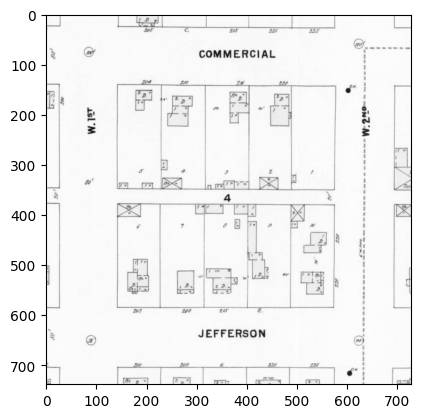

In [8]:
img = cv.imread(cv.samples.findFile(file_path))
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
kernel = np.ones((5,1),np.uint8)
dilate = cv.dilate(~gray,kernel,iterations = 18)
plt.imshow(gray, 'gray')
plt.show()

# Sharpen image with edge enhancement

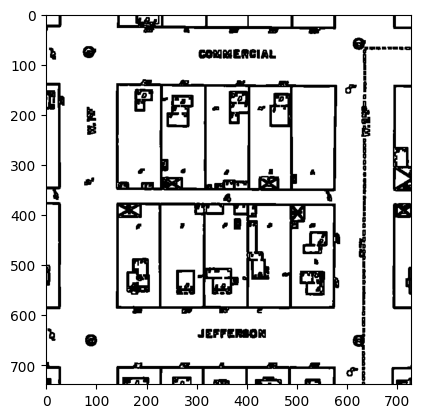

In [10]:
img = cv.imread(file_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(img_gray, (3, 3), 0)
_, img_thr = cv.threshold(~blurred, 20, 255, cv.THRESH_BINARY)
edges = cv.Canny(blurred, 0, 200)
kernel = np.ones((3,3),np.uint8)
dil_edge = cv.dilate(edges, kernel=kernel, iterations=1)
plt.imshow(~dil_edge, cmap='gray')
plt.show()

# Identify Connected Component

339


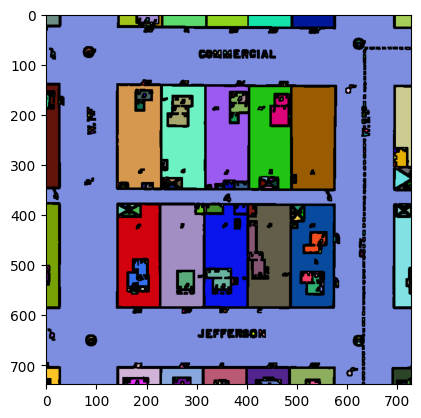

In [12]:
img = cv.imread(file_path)
num_labels, labels = cv.connectedComponents(~dil_edge)
print(num_labels)
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

colors[0] = [0, 0, 0]

output = np.zeros_like(img, dtype=np.uint8)
for label in range(0, num_labels):
    output[labels == label] = colors[label]

plt.imshow(output, cmap='gray')
plt.show()

## Roads are the largest connected component, filter by area

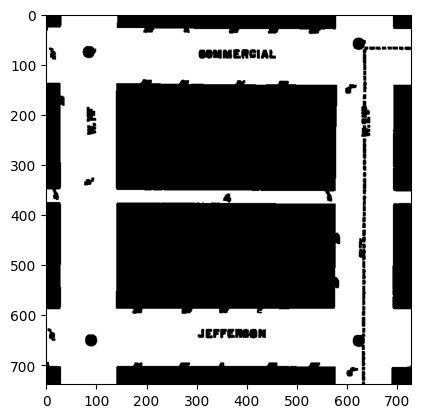

In [13]:
img = cv.imread(file_path)
num_labels, labels = cv.connectedComponents(~dil_edge)
component_areas = {}

for label in range(0, num_labels):
    component_mask = labels == label
    area = np.sum(component_mask)
    component_areas[label] = area

roads = np.zeros_like(dil_edge, dtype=np.uint8)
largest_label = max(component_areas, key=component_areas.get)
roads[labels == largest_label] = 1
# largest_area = component_areas[largest_label]
plt.imshow(roads, cmap='gray')
plt.show()

# Road Mask
## Close Image for cleaner Road Mask

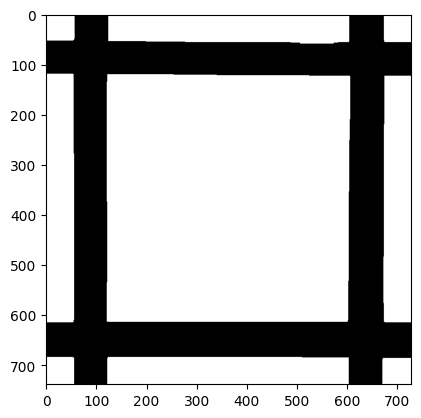

In [16]:
itr = 2
kernel = np.ones((12,12),np.uint8)
road_clean = cv.erode(~roads, kernel=kernel, iterations= itr)
road_clean = cv.dilate(road_clean, kernel=kernel, iterations=itr*3)
road_clean[road_clean < 255] = 0
plt.imshow(road_clean, cmap='gray')
plt.show()

In [17]:
road_clean_inv = ~road_clean
kernal = np.array([0, 0, 0, 1], dtype=np.uint8)
kernal = np.transpose(np.expand_dims(kernal, axis=0))
road_clean_inv1 = cv.erode(road_clean_inv, kernal, iterations=2)

# Road Thinning
## One Pixel road form

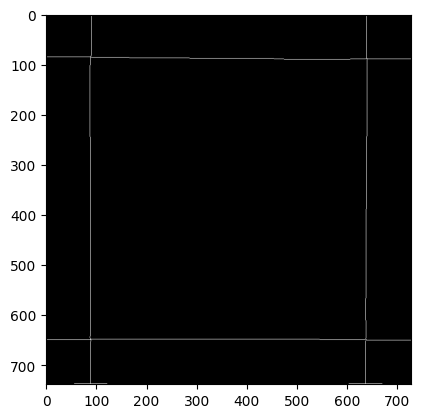

In [19]:
output_image1 = cv.ximgproc.thinning(~road_clean, cv.ximgproc.THINNING_ZHANGSUEN)
kernel = np.ones((5,5), np.uint8)  # You can adjust the size of the kernel according to your needs
plt.imshow(output_image1, cmap='gray')
plt.show()

## Image with road Mask

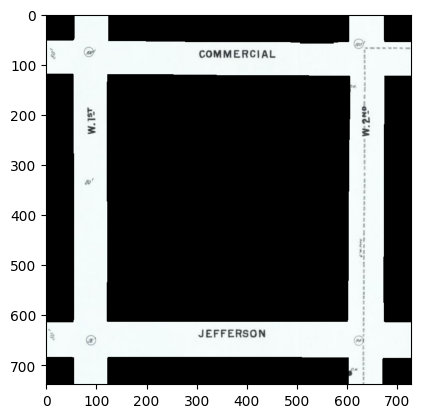

In [21]:
img = cv.imread(cv.samples.findFile(file_path))
img[(~road_clean) < 255]  = [0, 0, 0]
plt.imshow(img)
plt.show()

## Resize and further sharpen image for effective OCR

/var/folders/64/v39k3dlx3kl6dhmf1gjqpmr4rlcd68/T/ipykernel_27327/3463360955.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


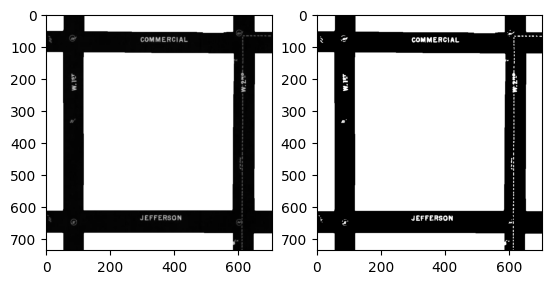

In [30]:
h, w = img.shape[:2]
nh = np.int32(h / 32) * 32
nw = np.int32(w / 32) * 32
resizeRatioh = h/nh
resizeRatiow = w/nw
resize_img = cv.resize(img, (nw, nh))
imgcln = ~resize_img[:,:,1]
itr1 = 1
fig, ax = plt.subplots(1, 2)
ax[0].imshow(~resize_img[:,:,1], cmap='gray')
kernel = np.ones((2,2),np.uint8)
imgcln = cv.erode(imgcln,kernel,iterations = itr1)
imgcln = cv.dilate(imgcln,kernel,iterations = itr1)
resize_img[imgcln < 50] = [0, 0, 0]
resize_img[imgcln > 50] = [255, 255, 255]
ax[1].imshow(resize_img, cmap='gray')
fig.show()

In [31]:
def forward_passer(net, image, layers, timing=True):
    """
    Returns results from a single pass on a Deep Neural Net for a given list of layers
    :param net: Deep Neural Net (usually a pre-loaded .pb file)
    :param image: image to do the pass on
    :param layers: layers to do the pass through
    :param timing: show detection time or not
    :return: results obtained from the forward pass
    """
    h, w = image.shape[:2]
    blob = cv.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    # start = time.time()
    net.setInput(blob)
    scores, geometry = net.forward(layers)
    # end = time.time()

    # if timing:
        # print(f"[INFO] detection in {round(end - start, 2)} seconds")

    return scores, geometry


def box_extractor(scores, geometry, min_confidence):
    """
    Converts results from the forward pass to rectangles depicting text regions & their respective confidences
    :param scores: scores array from the model
    :param geometry: geometry array from the model
    :param min_confidence: minimum confidence required to pass the results forward
    :return: decoded rectangles & their respective confidences
    """
    num_rows, num_cols = scores.shape[2:4]
    rectangles = []
    confidences = []

    for y in range(num_rows):
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(num_cols):
            if scores_data[x] < min_confidence:
                continue

            offset_x, offset_y = x * 4.0, y * 4.0

            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            box_h = x_data0[x] + x_data2[x]
            box_w = x_data1[x] + x_data3[x]

            end_x = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
            end_y = int(offset_y + (cos * x_data2[x]) - (sin * x_data1[x]))
            start_x = int(end_x - box_w)
            start_y = int(end_y - box_h)

            rectangles.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])

    return rectangles, confidences

## Text Detection using ETD model

In [32]:
net = cv.dnn.readNet('./frozen_east_text_detection.pb')
layer_names = ['feature_fusion/Conv_7/Sigmoid',
                   'feature_fusion/concat_3']
scores, geometry = forward_passer(net, resize_img, layers=layer_names)
rectangles, confidences = box_extractor(scores, geometry, 0.5)
boxes = non_max_suppression(np.array(rectangles), probs=confidences)

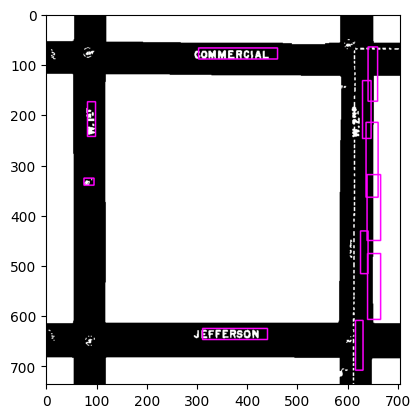

In [35]:
resize_img1 = ~resize_img
for (start_x, start_y, end_x, end_y) in boxes:
    start_x = int(start_x * resizeRatiow)
    start_y = int(start_y * resizeRatioh)
    end_x = int(end_x * resizeRatiow)
    end_y = int(end_y * resizeRatioh)

    cv.rectangle(resize_img1, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

plt.imshow(~resize_img1, cmap='gray')

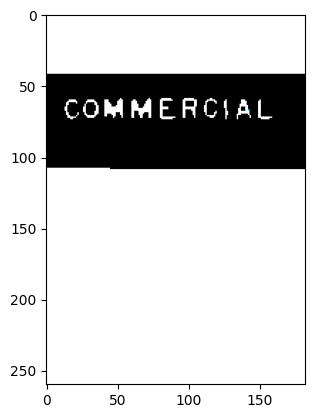

Commercial Street


In [82]:
(start_x, start_y, end_x, end_y) = boxes[3]

start_x = int(start_x * resizeRatiow)
start_y = int(start_y * resizeRatioh)
end_x = int(end_x * resizeRatiow)
end_y = int(end_y * resizeRatioh)
dx = int((end_x - start_x) * 3)
dy = int((end_y - start_y) * 3)
start_x = max(0, start_x - dx)
start_y = max(0, start_y - dy)
end_x = min(w, end_x + (dx*3))
end_y = min(h, end_y + (dy*3))
roi = resize_img[start_x:end_x, start_y:end_y]
_, img_thr = cv.threshold(~roi, 20, 255, cv.THRESH_BINARY)
kernel = np.ones((2,2),np.uint8)
img_thr1 = cv.erode(~img_thr,kernel,iterations = 2)
# img_thr1 = ~img_thr
# img_thr1 = cv.rotate(~img_thr1, cv.ROTATE_90_CLOCKWISE)
plt.imshow(img_thr1, cmap='gray')
plt.show()


pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
config = '-l eng --oem 1 --psm 7'
# text = pytesseract.image_to_string(img_thr1, config=config)
dataframe = pytesseract.image_to_data(img_thr1, config=config, output_type="data.frame")
text = ''.join(dataframe[dataframe['conf'] > 65]['text'])
Y = bag_of_char(["{} street".format(text)])
X = bag_of_char(np.array(street_names['streetname']))
print(street_names['streetname'][np.argmax(cosine_similarity(X, Y))])

## Text Recognition

In [39]:
roations=[None, cv.ROTATE_90_CLOCKWISE]
kernels=[np.ones((2,2),np.uint8)]
data = {'start_x': [],
        'start_y': [],
        'end_x': [],
        'end_y': [],
        'cen_x': [],
        'cen_y': [], 
        'text': []}
df = pd.DataFrame(data)

In [40]:
import re
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
config = '-l eng --oem 1 --psm 11'
X = bag_of_char(np.array(street_names['streetname']))
i = -1
for (start_x, start_y, end_x, end_y) in boxes:
    i+=1
    data = np.empty((0,), dtype=np.str_)
    start_x = int(start_x * resizeRatiow)
    start_y = int(start_y * resizeRatioh)
    end_x = int(end_x * resizeRatiow)
    end_y = int(end_y * resizeRatioh)
    cen_x = int(start_x* 0.5 + end_x*0.5)
    cen_y = int(start_y* 0.5 + end_y*0.5)
    dx = int((end_x - start_x) * 2)
    dy = int((end_y - start_y) * 2)
    start_x = max(0, start_x - dx)
    start_y = max(0, start_y - dy)
    end_x = min(w, end_x + (dx*1))
    end_y = min(h, end_y + (dy*1))
    
    orientation = "horizontal"
    if (end_y - start_y) > (end_x - start_x):
        orientation = "vertical"
    data = np.append(np.array([start_x, start_y, end_x, end_y, cen_x, cen_y]), data)
    roi = resize_img[start_y:end_y, start_x:end_x]
    maxConfText = ""
    maxConf = 0.6
    for kernel in kernels:
        for rotation in roations:
            _, img_thr = cv.threshold(~roi, 20, 255, cv.THRESH_BINARY)
            img_thr1 = cv.erode(~img_thr,kernel,iterations = 1)
            if rotation in [cv.ROTATE_90_CLOCKWISE, cv.ROTATE_90_COUNTERCLOCKWISE] and orientation == "horizontal":
                continue
            if rotation in [cv.ROTATE_180] and orientation == "vertical":
                continue
            if rotation != None:
                img_thr1 = cv.rotate(~img_thr1, rotateCode=rotation)
            else:
                img_thr1 = ~img_thr1
            dataframe = pytesseract.image_to_data(img_thr1, config=config, output_type="data.frame")
            text = ''.join(dataframe[dataframe['conf'] > 50]['text'].astype(np.str_))
            if text not in ['nan', '', 'NaN']:
                # print(text)
                alphanumeric_chars = re.findall(r'\w', text)
                Y = bag_of_char(["{} street".format(alphanumeric_chars)])
                conf = np.max(cosine_similarity(X, Y))
                if maxConf < conf:
                    # maxConf = conf
                    maxConfText = street_names['streetname'][np.argmax(cosine_similarity(X, Y))]
                    data1 = np.append(data, [maxConfText])
                    new_row = pd.Series(data1, index=df.columns)
                    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=False)

In [48]:
df

,start_x,start_y,end_x,end_y,cen_x,cen_y,text
0,0,23,729,133,381,78,Commercial Street
0,53,581,698,691,375,636,Jefferson Street
0,602,0,697,389,649,119,W 1st Street
0,50,36,130,381,90,208,W 2nd Street


# Seed point
## Map road centroid to closest road in one pixel form

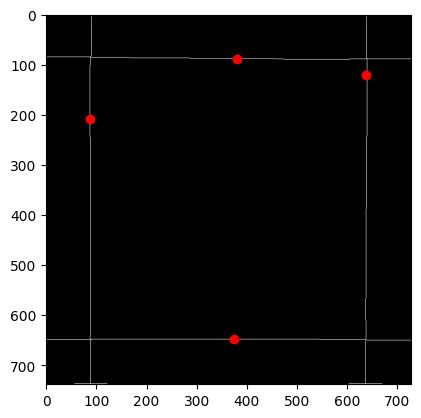

In [50]:
def find_closest_white_pixel(image, coord):
    white_pixels = np.array(np.where(image == 255)).T
    distances = np.linalg.norm(white_pixels - coord, axis=1)
    closest_index = np.argmin(distances)
    closest_white_pixel_coord = white_pixels[closest_index]
    
    return closest_white_pixel_coord

plt.imshow(output_image1, cmap='gray')
for idx, rec in df.iterrows():
    coord = find_closest_white_pixel(output_image1, [int(rec['cen_y']), int(rec['cen_x'])])
    plt.plot(coord[1], coord[0], 'ro')  # 'ro' specifies red circles
plt.show()

# Identify intersection

## Voting

In [51]:
def get_max_neighboring_pixels(image):
    max_count = 0
    max_coords = []

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            count = 0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    if 0 <= i + di < image.shape[0] and 0 <= j + dj < image.shape[1]:
                        if image[i + di, j + dj] == 255:
                            count += 1
            if count > 3:
                is_close = False
                result = tuple((i - t[0], j - t[1]) for t in max_coords)
                vals = list((abs(t[0]) + abs(t[1]) for t in result))
                if len(vals) > 0:
                    if min(vals) < 80:
                        is_close = True
                if not is_close:
                    max_count = count
                    max_coords.append((i, j))

    return max_coords, max_count

inter = get_max_neighboring_pixels(output_image1)


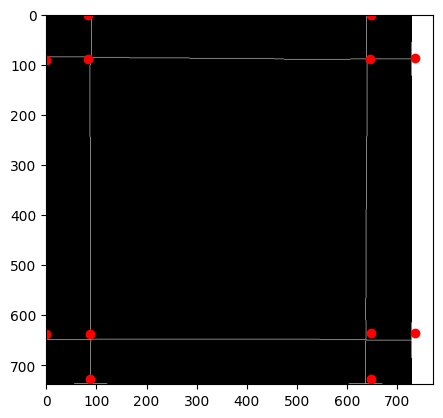

In [55]:
plt.imshow(output_image1, cmap='gray')
for x, y in inter[0]:
    plt.plot(x, y, 'ro')  # 'ro' specifies red circles
plt.show()

# Rectangle for true intersection identification

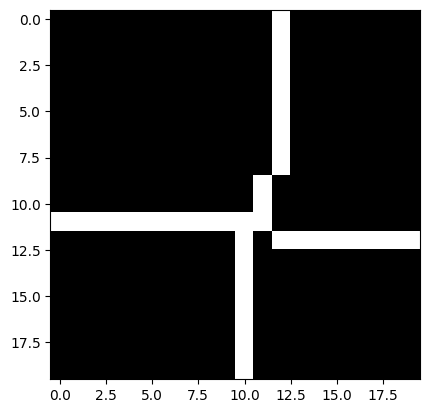

In [64]:
plt.imshow(output_image1[74:94, 78: 98], cmap='gray')
plt.show()

In [65]:
import math
def get_intersection_angle(x1, x2, y1, y2):
    angle = abs(math.degrees(math.atan((x2 - x1) / (y2 - y1))))
    return  (angle < 80 and angle > 40), angle

In [66]:
def get_true_interection(inter):
    true_intersections = []
    diff = 10
    for x, y in inter[0]:
        if x != 0 and y != 0:
            val = output_image1[max(0, x-diff):min(x+diff, len(output_image1)-1), max(0, y-diff): min(y+diff, len(output_image1[0])-1)]
            array = []
            array.append(list((0, t) for t in np.where(val[0] == 255)[0]))
            array.append(list((t, 0) for t in np.where(val[:, 0] == 255)[0]))
            array.append(list((len(val[0])-1, t) for t in np.where(val[len(val)-1] == 255)[0]))
            array.append(list((t, len(val[0])-1) for t in np.where(val[:, len(val[0])-1] == 255)[0]))
            array = [sub_array for sub_array in array if sub_array]
            count = 0
            for i in range(len(array)):
                for j in range(len(array)):
                    if i != j and (array[i][0][0] != array[j][0][0] or array[i][0][1] != array[j][0][1]):
                        x1, y1 = array[i][0]
                        x2, y2 = array[j][0]
                        if get_intersection_angle(x1, x2, y1, y2)[0]:
                            count +=1
            if count > 3:
                true_intersections.append([x,y])
    return true_intersections

/var/folders/64/v39k3dlx3kl6dhmf1gjqpmr4rlcd68/T/ipykernel_27327/3188331954.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  angle = abs(math.degrees(math.atan((x2 - x1) / (y2 - y1))))


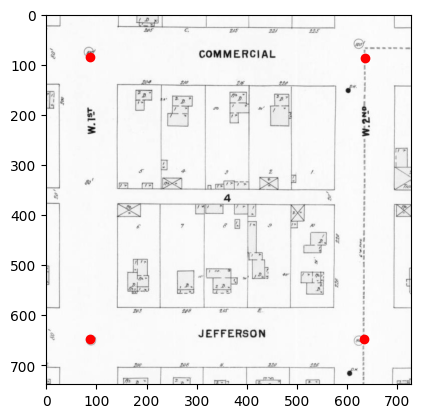

In [67]:
# intersect = np.array([[343, 2628], [2629,498], [2666,2624], [499,488]])
intersect = get_true_interection(inter)
img = cv.imread(file_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
for x in intersect:
    plt.plot(x[1], x[0], 'ro')
plt.show()

## Intersection and seed points

/var/folders/64/v39k3dlx3kl6dhmf1gjqpmr4rlcd68/T/ipykernel_27327/3188331954.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  angle = abs(math.degrees(math.atan((x2 - x1) / (y2 - y1))))


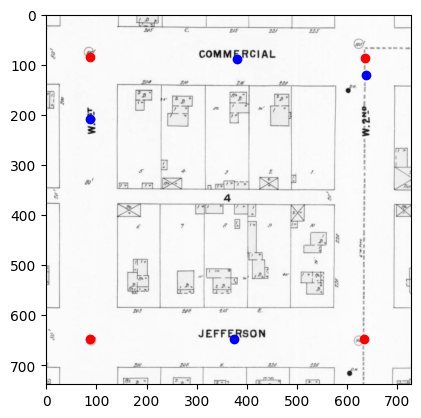

In [69]:
intersect = get_true_interection(inter)
seed_points = []
for idx, rec in df.iterrows():
    coord = find_closest_white_pixel(output_image1, [int(rec['cen_y']), int(rec['cen_x'])])
    # seed_points.append(coord)
    seed_points = seed_points + [coord]
img = cv.imread(file_path)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
i = 0
for x in intersect:
    plt.plot(x[1], x[0], 'ro')
for s in seed_points:
        plt.plot(s[1], s[0], 'bo')  # 'ro' specifies red circles
plt.show()

In [70]:
# 
# seed = seed_points[3]
count_val = [[[-1, -1],[-1, 0], [-1, 1]],
             [[0, -1],[0, 0], [0, 1]],
             [[1, -1],[1, 0], [1, 1]]]
# def find_intersection_for_dir(seed, img)
def find_intersection_seed(seed, img):
    arr = []
    x, y = seed
    img[x, y] = 0
    val = img[x-1:x+2, y-1:y+2]
    next_path = np.where(val == 255)
    for path in range(len(next_path[0])):
        ax, ay = count_val[next_path[0][path]][next_path[1][path]]
        abs_x = x + ax
        abs_y = y + ay
        is_intersect = False
        intr_id = 0
        for x, y in intersect:
            if abs(x - seed[0]) < 2 and (y - seed[1]) < 2:
                is_intersect = True
                break
            intr_id += 1
        if is_intersect:
            return [intr_id]
        else:
            arr = arr + find_intersection_seed([abs_x, abs_y], img)
    return arr


In [72]:
import copy
# df.iat[0, 6]
road_inter = {}
i = 0
output_image2 = copy.deepcopy(output_image1)
for seed in seed_points:
    road_intersects = np.unique(np.array(find_intersection_seed(seed, output_image2)))
    for intersect1 in road_intersects:
        arry = [i]
        if intersect1 in road_inter:
            val = road_inter[intersect1]
            arry = val + arry
        road_inter[intersect1] = arry
    i += 1

In [73]:
result = []
for intersection in road_inter:
    # raods = intersection
    for i in range(len(road_inter[intersection])):
        for j in range(i, len(road_inter[intersection])):
            if i != j:
                dict = {"address": "{0} & {1}".format(df.iat[i, 6], df.iat[j, 6]), "y": intersect[intersection][1], "x": intersect[intersection][0]}
                result.append(dict)

In [74]:
result

[{'address': 'Commercial Street & Jefferson Street', 'y': 88, 'x': 84},
 {'address': 'Commercial Street & Jefferson Street', 'y': 88, 'x': 647},
 {'address': 'Commercial Street & W 1st Street', 'y': 88, 'x': 647},
 {'address': 'Jefferson Street & W 1st Street', 'y': 88, 'x': 647},
 {'address': 'Commercial Street & Jefferson Street', 'y': 635, 'x': 648}]

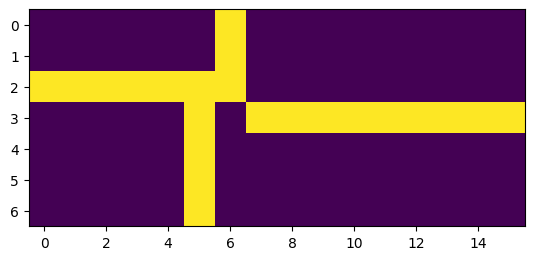

In [75]:
plt.imshow(output_image1[83:90, 83:99])
plt.show()